# Simple Example

## Introduction

In this example, we present an existing method [1] and our new method on a very simple simulated dataset. <br>
We compare both methods based on simplicity, goodness of fit and performance. <br>
<br>
[1] On the Analysis of Discrete Time Competing Risks Data, Biometrics, Lee et al. 2018

## Data Generation

We simulate N=50,000 patients, with 5 covariate $Z_p$ ($p \in [1,...,5]$) randomly sampled from $\mathbb{R} [0,1]$. <br> <br>
Our timeline is discrete, i.e $t \in [1,...,d]$. Here, we choose $d=30$. <br> <br>
The event type $J_i$ is randomly sampled from $J_i \sim Uniform[1,...,M]$, where $M$ is the number of competing events. In this example $M=2$. <br><br>
For each of the samples, we sample it's time-to-event $T_i$ from the hazard function $\lambda_{j}(T|Z) = \frac{exp(\alpha_{jt}+Z^{T}\beta_{j})}{1+exp(\alpha_{jt}+Z^{T}\beta_{j})}$ such that <br>
$\alpha_{1t} = -1-0.3 log(t)$ <br> 
$\beta_{1} = -log([0.8, 3, 3, 2.5, 2])$ <br> 
$\alpha_{2t} = -1.75-0.15 log(t)$ <br> 
$\beta_{2} = -log([1, 3, 4, 3, 2])$ <br> 

and randomly sample a censoring time $C_i$ such that $C_i \sim Uniform[1, ... , d]$. <br>
We then calculate $X_i = min(T_i, C_i)$ and for cencored samples we set the event type to be $J=0$. <br><br>
Lastly, we split the data into two separate datasets for training (75%) and for testing (25%).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
import warnings
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
n_patients = 50000
n_cov = 5
patients_df = generate_quick_start_df(n_patients=n_patients, n_cov=n_cov, d_times=30, j_events=2, 
                                      pid_col='pid', seed=0)
covariates = [f'Z{i + 1}' for i in range(n_cov)]

train_df, test_df = train_test_split(patients_df, test_size=0.25)
events = sorted(train_df['J'].unique())
times = sorted(train_df['X'].unique())
train_df.head()  

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
30836,30836,0.963039,0.862514,0.151403,0.013899,0.520010,1,1,6,1
30046,30046,0.727934,0.810600,0.400967,0.264497,0.405388,0,30,3,3
3462,3462,0.522687,0.114368,0.003367,0.573465,0.459525,0,21,8,8
16725,16725,0.738827,0.445443,0.347225,0.366962,0.670616,1,8,20,8
35944,35944,0.477982,0.883097,0.002242,0.772298,0.155511,0,30,3,3


## Lee et al. 2018 [1]

Lee et al. suggested to expand the data so that for each patient we have row for each $t \in [1, ... , T_i]$, with binary event columns which are 1 only at the time of the event. here $j_0 = 1 - j_1 - j_2$. <br> <br>
Then, for each event we estimate {$\alpha_{jt}, \beta_{j}$} using a binary regression model.

In [3]:
from pydts.fitters import DataExpansionFitter
fitter = DataExpansionFitter()
fitter.fit(df=train_df.drop(['C', 'T'], axis=1))
fitter.print_summary()



Model summary for event: 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    j_1   No. Observations:               358588
Model:                            GLM   Df Residuals:                   358553
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54055.
Date:                Sun, 27 Mar 2022   Deviance:                   1.0811e+05
Time:                        00:58:47   Pearson chi2:                 3.58e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01552
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(X)[1]       -0.9880  

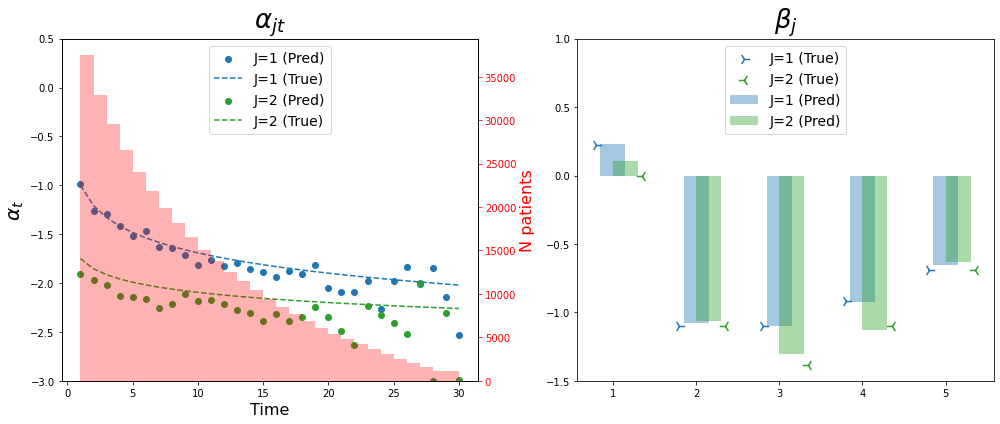

In [4]:
from pydts.examples_utils.plots import plot_first_model_coefs
plot_first_model_coefs(models=fitter.event_models, times=times, expanded_train_df=fitter.expanded_df, 
                       n_cov=5)

## New approach

Here, for each event, we first estimate $\beta_{j}$ using a time-stratified CoxPH model and the expanded data as we used in the previous approach. <br> <br>
Afterwards, we evaluate $\alpha_{jt}$ based on the original training data.

In [5]:
from pydts.fitters import TwoStagesFitter
new_fitter = TwoStagesFitter()
new_fitter.fit(df=train_df.drop(['C', 'T'], axis=1))

new_fitter.print_summary()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Model summary for event: 1


<lifelines.CoxPHFitter: fitted with 358588 total observations, 345290 right-censored observations>
             duration col = 'X'
                event col = 'j_1'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 358588
number of events observed = 13298
   partial log-likelihood = -130518.14
         time fit was run = 2022-03-26 21:58:48 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.22       1.25       0.03             0.16             0.28                 1.18                 1.33
Z2         -1.05       0.35       0.03            -1.11            -0.99                 0.33                 0.37
Z3         -1.07       0.34       0.03            -1.13            -1.01                 0.32                 0.36
Z4         -0.90       0.41       0.03            -0.96            -0.84                 0.38                 0.43
Z5         -0.64       0.53       0.03            -0.69            -0.58                 0.50                 0.56

               z      p   -log2(p)
covariate                         
Z1          7.43 <0.005      43.02
Z2        -34.29 <0.005     853.48
Z3        -34.93 <0.005     885.65
Z4        -29.49 <0.005     632.71
Z5        -21.02 <0.005     323.50
---
Concordance = 0.65
Partial AIC = 261046.28
log-likelihood ratio test = 3561.38 on 5 df
-log2(p) of ll-ratio test = inf

n_jt  success  alpha_jt
J X                          
1 1   2550     True -1.028945
  2   1686     True -1.303045
  3   1431     True -1.337755
  4   1130     True -1.453139
  5    902     True -1.562932
  6    847     True -1.513146
  7    651     True -1.672195
  8    575     True -1.689133
  9    482     True -1.761674
  10   393     True -1.862559
  11   376     True -1.805243
  12   318     True -1.869999
  13   296     True -1.836023
  14   249     True -1.899833
  15   217     True -1.928007
  16   185     True -1.988058
  17   175     True -1.918037
  18   151     True -1.946439
  19   145     True -1.861054
  20   101     True -2.101155
  21    85     True -2.135540
  22    74     True -2.138152
  23    71     True -2.024084
  24    45     True -2.304204
  25    49     True -2.028465
  26    45     True -1.880831
  27    29     True -2.062382
  28    24     True -1.891419
  29    12     True -2.185617
  30     4     True -2.576843



Model summary for event: 2


<lifelines.CoxPHFitter: fitted with 358588 total observations, 352834 right-censored observations>
             duration col = 'X'
                event col = 'j_2'
                   strata = X_copy
      baseline estimation = breslow
   number of observations = 358588
number of events observed = 5754
   partial log-likelihood = -55924.25
         time fit was run = 2022-03-26 21:58:49 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Z1          0.11       1.11       0.05             0.02             0.20                 1.02                 1.22
Z2         -1.05       0.35       0.05            -1.14            -0.96                 0.32                 0.38
Z3         -1.29       0.28       0.05            -1.38            -1.19                 0.25                 0.30
Z4         -1.12       0.33       0.05            -1.21            -1.03                 0.30                 0.36
Z5         -0.62       0.54       0.05            -0.71            -0.53                 0.49                 0.59

               z      p   -log2(p)
covariate                         
Z1          2.38   0.02       5.83
Z2        -22.69 <0.005     376.24
Z3        -27.45 <0.005     548.54
Z4        -24.01 <0.005     420.61
Z5        -13.57 <0.005     136.97
---
Concordance = 0.66
Partial AIC = 111858.50
log-likelihood ratio test = 1922.02 on 5 df
-log2(p) of ll-ratio test = inf

n_jt  success  alpha_jt
J X                          
2 1    874     True -1.915826
  2    694     True -1.988731
  3    575     True -2.042675
  4    455     True -2.146348
  5    399     True -2.154726
  6    348     True -2.176848
  7    283     True -2.263443
  8    264     True -2.224185
  9    262     True -2.125964
  10   219     True -2.195902
  11   199     True -2.189484
  12   172     True -2.228189
  13   146     True -2.279440
  14   127     True -2.305106
  15   105     True -2.375194
  16   101     True -2.312035
  17    83     True -2.378531
  18    77     True -2.338007
  19    75     True -2.244697
  20    59     True -2.337922
  21    45     True -2.495129
  22    34     True -2.625910
  23    43     True -2.233395
  24    33     True -2.313774
  25    25     True -2.423878
  26    18     True -2.519975
  27    23     True -2.011791
  28     6     True -2.895408
  29     8     True -2.286857
  30     2     True -2.890292

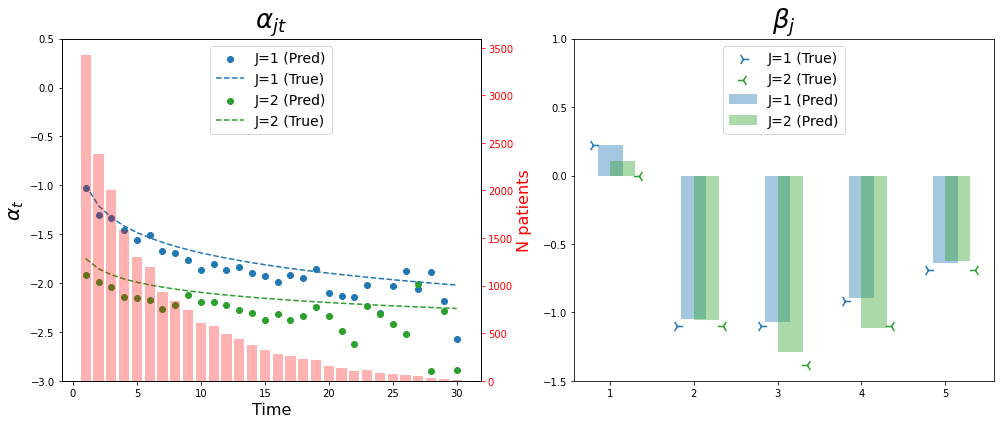

In [6]:
from pydts.examples_utils.plots import plot_second_model_coefs
plot_second_model_coefs(new_fitter.alpha_df, new_fitter.beta_models, times, n_cov=5)

In [7]:
new_fitter.get_beta_SE()

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.223032,0.030034,0.108418,0.045643
Z2,-1.046514,0.030521,-1.052748,0.046395
Z3,-1.069749,0.030624,-1.286462,0.046870
Z4,-0.896712,0.030403,-1.117006,0.046531
Z5,-0.635528,0.030232,-0.623618,0.045949


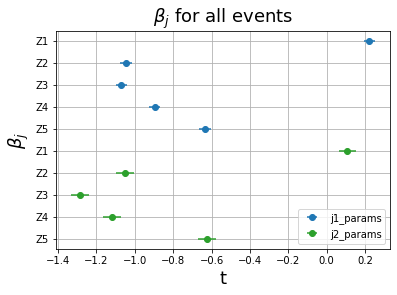

<AxesSubplot:title={'center':'$\\beta_{j}$ for all events'}, xlabel='t', ylabel='$\\beta_{j}$'>

In [8]:
new_fitter.plot_all_events_beta()

## Prediction

In [9]:
pred_df = new_fitter.predict_cumulative_incident_function(test_df)
pred_df = new_fitter.predict_marginal_prob_all_events(pred_df)
pred_df.set_index(['pid']).head().T

pid,27909,43124,48015,40407,48981
Z1,0.554105,0.163763,0.488750,0.792177,0.981525
Z2,0.624893,0.717547,0.581979,0.659144,0.402432
Z3,0.068067,0.042231,0.930778,0.200388,0.203951
Z4,0.678803,0.008311,0.349196,0.931243,0.223582
Z5,0.916602,0.593082,0.868810,0.712019,0.613302
J,0.000000,0.000000,0.000000,1.000000,2.000000
T,13.000000,30.000000,30.000000,4.000000,1.000000
C,11.000000,20.000000,6.000000,11.000000,1.000000
X,11.000000,20.000000,6.000000,4.000000,1.000000
overall_survival_t1,0.924679,0.854139,0.957485,0.940678,0.842914


## Comparison (WIP)

In [10]:
pd.DataFrame(index=pd.MultiIndex.from_product([['d=30', 'd=60', 'd=100', 'd=150'],
                                               ['N=1000', 'N=10000', 'N=100000']], names=['N', 'D']), 
             columns=['Train MSE (oracle)', 'Test MSE (oracle)', 'computation time'])

Train MSE (oracle) Test MSE (oracle) computation time
N     D                                                             
d=30  N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=60  N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=100 N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN
d=150 N=1000                  NaN               NaN              NaN
      N=10000                 NaN               NaN              NaN
      N=100000                NaN               NaN              NaN

In [11]:
from pydts.examples_utils.plots import compare_beta_models_for_example
from pydts.utils import present_coefs

res_dict = compare_beta_models_for_example(fitter.event_models, new_fitter.event_models)

present_coefs(res_dict)

for coef: Alpha


,lee,new,real
a1_1,-0.988002,-1.028945,-1.000000
a2_1,-1.261246,-1.303045,-1.207944
a3_1,-1.295459,-1.337755,-1.329584
a4_1,-1.411197,-1.453139,-1.415888
a5_1,-1.522728,-1.562932,-1.482831
a6_1,-1.471481,-1.513146,-1.537528
a7_1,-1.627933,-1.672195,-1.583773
a8_1,-1.644553,-1.689133,-1.623832
a9_1,-1.717455,-1.761674,-1.659167
a10_1,-1.820196,-1.862559,-1.690776


for coef: Beta


,lee,new,real
Z1_1,0.230887,0.223032,0.223144
Z2_1,-1.075919,-1.046514,-1.098612
Z3_1,-1.100204,-1.069749,-1.098612
Z4_1,-0.922627,-0.896712,-0.916291
Z5_1,-0.654426,-0.635528,-0.693147
Z1_2,0.109348,0.108418,-0.000000
Z2_2,-1.064902,-1.052748,-1.098612
Z3_2,-1.301651,-1.286462,-1.386294
Z4_2,-1.130381,-1.117006,-1.098612
Z5_2,-0.631260,-0.623618,-0.693147


In [12]:
from pydts.fitters import create_df_for_cif_plots

df_for_plotting = create_df_for_cif_plots(test_df, field="Z1", covariates=new_fitter.covariates,
                                                     quantiles=[0.25, 0.5, 0.75], zero_others=True )
pred_df = new_fitter.predict_cumulative_incident_function(df_for_plotting)
pred_df = new_fitter.predict_marginal_prob_all_events(pred_df)

pred_df.head()

,Z1,Z2,Z3,Z4,Z5,overall_survival_t1,overall_survival_t2,overall_survival_t3,overall_survival_t4,overall_survival_t5,...,cif_j2_at_t23,cif_j2_at_t24,cif_j2_at_t25,cif_j2_at_t26,cif_j2_at_t27,cif_j2_at_t28,cif_j2_at_t29,cif_j2_at_t30,marginal_prob_j1,marginal_prob_j2
27909,0.254200,0.0,0.0,0.0,0.0,0.594125,0.388158,0.258127,0.179227,0.127613,...,0.345615,0.345712,0.345783,0.345835,0.345899,0.345920,0.345951,0.345965,0.653807,0.345965
27909,0.506302,0.0,0.0,0.0,0.0,0.579637,0.371221,0.242192,0.165319,0.115870,...,0.340588,0.340661,0.340714,0.340751,0.340798,0.340814,0.340835,0.340845,0.659000,0.340845
27909,0.754562,0.0,0.0,0.0,0.0,0.565037,0.354497,0.226763,0.152086,0.104875,...,0.335810,0.335863,0.335902,0.335929,0.335963,0.335974,0.335989,0.335996,0.663900,0.335996


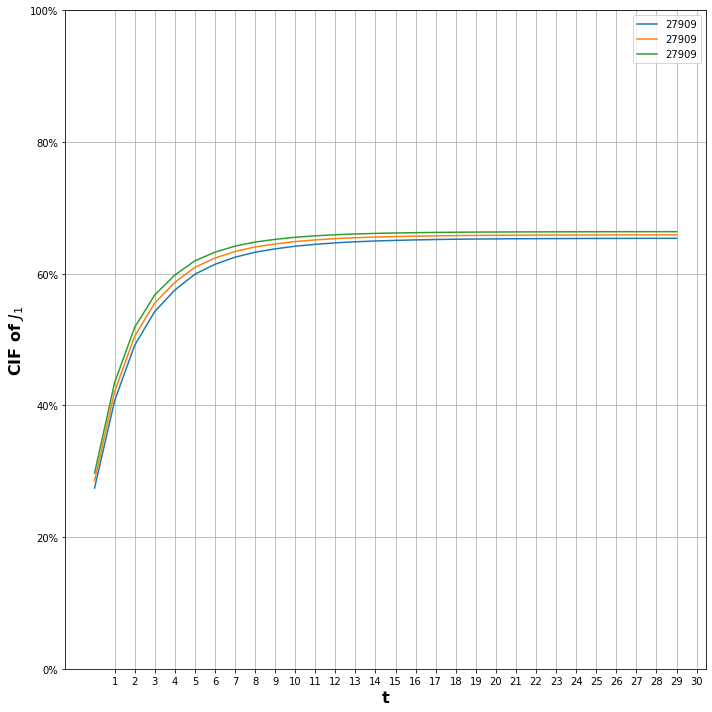

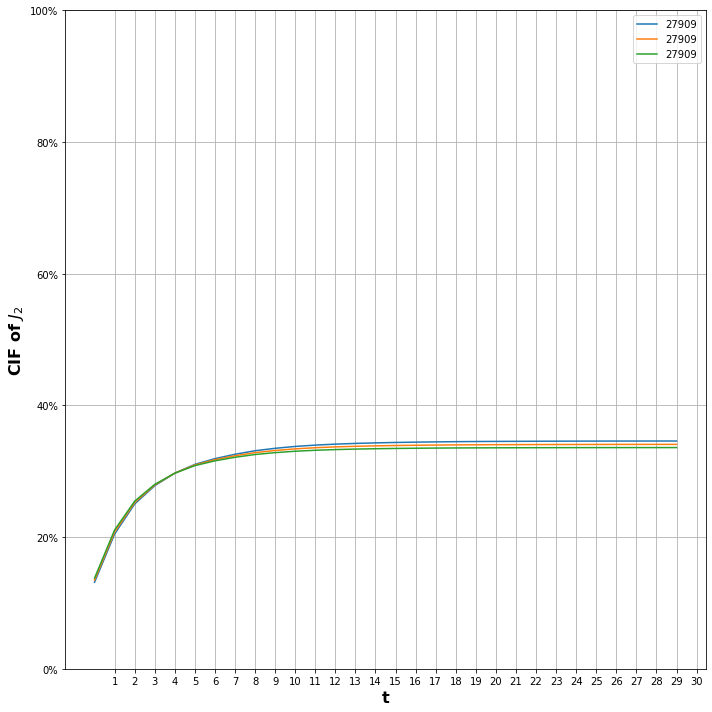

In [13]:
from pydts.examples_utils.plots import plot_cif_plots

plot_cif_plots(pred_df, event=1)
plot_cif_plots(pred_df, event=2)

In [14]:
pred_df = fitter.predict_cumulative_incident_function(df_for_plotting)
pred_df = fitter.predict_marginal_prob_all_events(pred_df)

pred_df.head()

,Z1,Z2,Z3,Z4,Z5,overall_survival_t1,overall_survival_t2,overall_survival_t3,overall_survival_t4,overall_survival_t5,...,cif_j2_at_t23,cif_j2_at_t24,cif_j2_at_t25,cif_j2_at_t26,cif_j2_at_t27,cif_j2_at_t28,cif_j2_at_t29,cif_j2_at_t30,marginal_prob_j1,marginal_prob_j2
27909,0.254200,0.0,0.0,0.0,0.0,0.584021,0.375835,0.246324,0.168899,0.118929,...,0.340558,0.340635,0.340693,0.340735,0.340787,0.340802,0.340826,0.340837,0.658984,0.340837
27909,0.506302,0.0,0.0,0.0,0.0,0.568852,0.358360,0.230125,0.154945,0.107287,...,0.335385,0.335442,0.335485,0.335514,0.335551,0.335562,0.335579,0.335586,0.664295,0.335586
27909,0.754562,0.0,0.0,0.0,0.0,0.553568,0.341133,0.214485,0.141721,0.096441,...,0.330482,0.330523,0.330554,0.330575,0.330601,0.330608,0.330620,0.330624,0.669298,0.330624


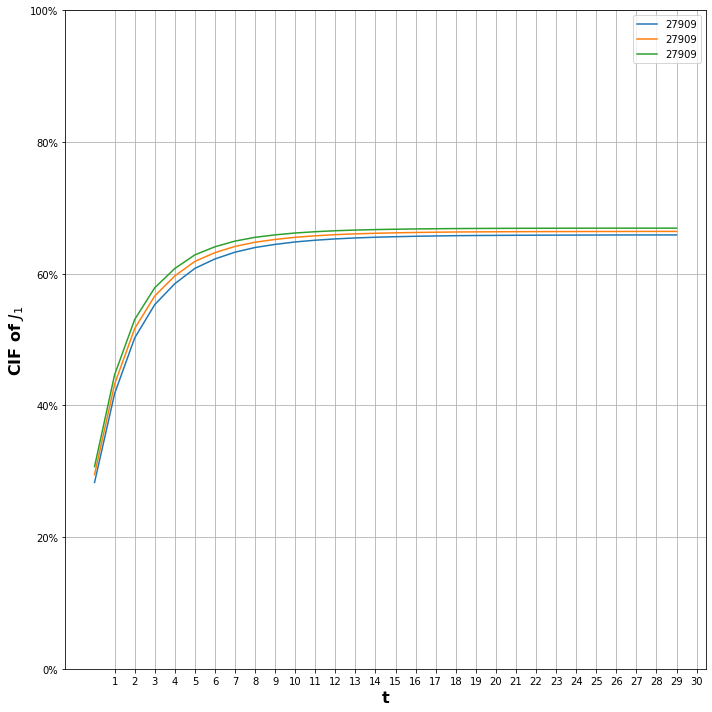

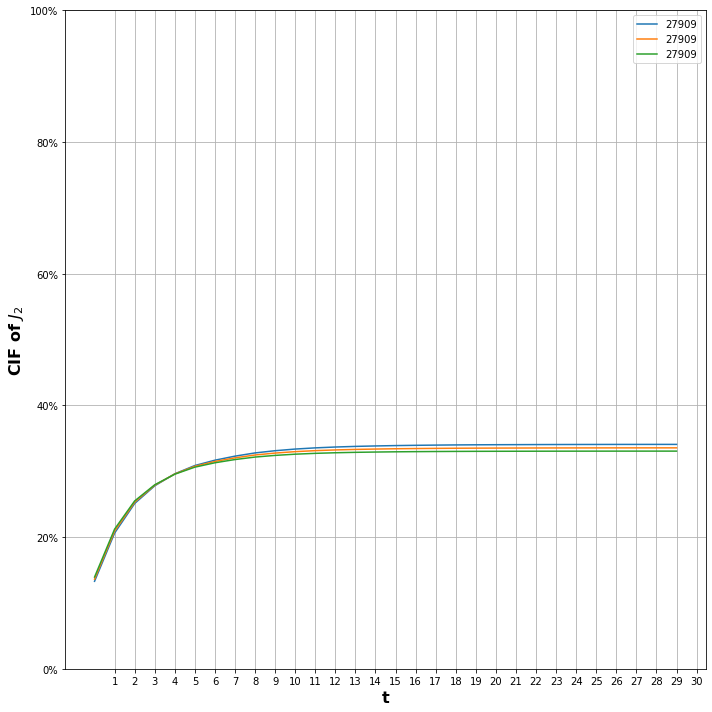

In [15]:
plot_cif_plots(pred_df, event=1)
plot_cif_plots(pred_df, event=2)

In [16]:
import numpy as np
# from joblib import Parallel, delayed
from scipy.special import expit

real_coef_dict = {
    "alpha": {
        1: lambda t: -1 - 0.3 * np.log(t),
        2: lambda t: -1.75 - 0.15 * np.log(t)
    },
    "beta": {
        1: -np.log([0.8, 3, 3, 2.5, 2]),
        2: -np.log([1, 3, 4, 3, 2])
    }
}

from pydts.fitters import get_real_hazard

df_temp = get_real_hazard(df_for_plotting.copy(), real_coef_dict=real_coef_dict, times=times, events=[1,2])
df_temp

,Z1,Z2,Z3,Z4,Z5,hazard_j1_t1,hazard_j1_t2,hazard_j1_t3,hazard_j1_t4,hazard_j1_t5,...,hazard_j2_t21,hazard_j2_t22,hazard_j2_t23,hazard_j2_t24,hazard_j2_t25,hazard_j2_t26,hazard_j2_t27,hazard_j2_t28,hazard_j2_t29,hazard_j2_t30
27909,0.254200,0.0,0.0,0.0,0.0,0.280239,0.240266,0.218768,0.204376,0.193706,...,0.099152,0.098531,0.09794,0.097378,0.096841,0.096327,0.095836,0.095364,0.094911,0.094475
27909,0.506302,0.0,0.0,0.0,0.0,0.291725,0.250684,0.228534,0.213676,0.202644,...,0.099152,0.098531,0.09794,0.097378,0.096841,0.096327,0.095836,0.095364,0.094911,0.094475
27909,0.754562,0.0,0.0,0.0,0.0,0.303302,0.261233,0.238448,0.223131,0.211742,...,0.099152,0.098531,0.09794,0.097378,0.096841,0.096327,0.095836,0.095364,0.094911,0.094475


In [17]:
pred_df2 = new_fitter.predict_cumulative_incident_function(df_temp)
pred_df2 = new_fitter.predict_marginal_prob_all_events(pred_df2)

pred_df2.head()

,Z1,Z2,Z3,Z4,Z5,hazard_j1_t1,hazard_j1_t2,hazard_j1_t3,hazard_j1_t4,hazard_j1_t5,...,cif_j2_at_t23,cif_j2_at_t24,cif_j2_at_t25,cif_j2_at_t26,cif_j2_at_t27,cif_j2_at_t28,cif_j2_at_t29,cif_j2_at_t30,marginal_prob_j1,marginal_prob_j2
27909,0.254200,0.0,0.0,0.0,0.0,0.280239,0.240266,0.218768,0.204376,0.193706,...,0.361229,0.361278,0.361316,0.361345,0.361367,0.361384,0.361398,0.361408,0.638506,0.361408
27909,0.506302,0.0,0.0,0.0,0.0,0.291725,0.250684,0.228534,0.213676,0.202644,...,0.351029,0.351067,0.351095,0.351117,0.351134,0.351147,0.351157,0.351165,0.648773,0.351165
27909,0.754562,0.0,0.0,0.0,0.0,0.303302,0.261233,0.238448,0.223131,0.211742,...,0.341270,0.341298,0.341320,0.341337,0.341349,0.341359,0.341366,0.341372,0.658583,0.341372


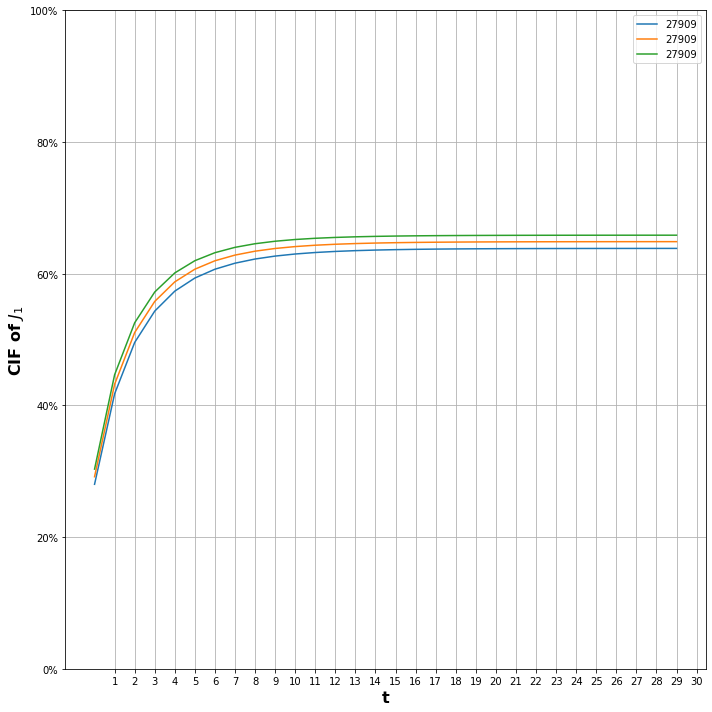

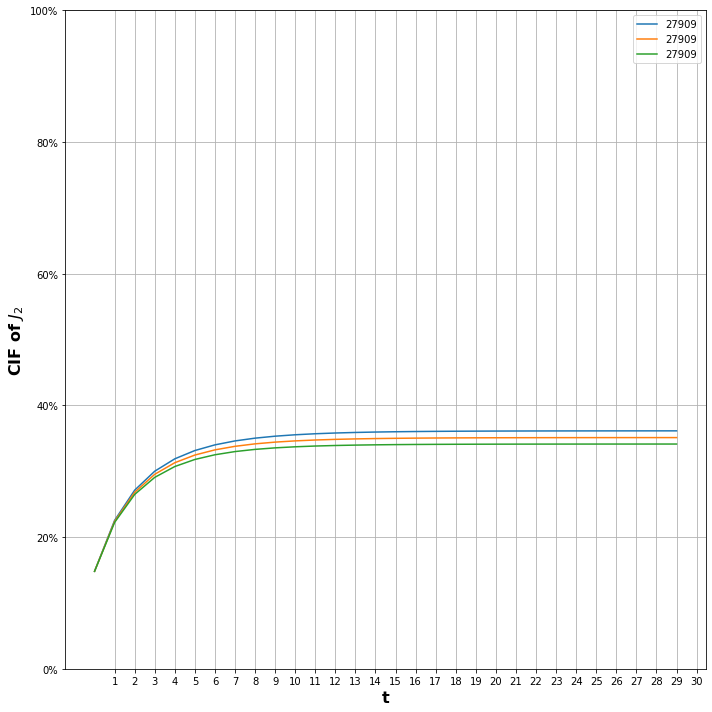

In [18]:
plot_cif_plots(pred_df2, event=1)
plot_cif_plots(pred_df2, event=2)

In [19]:
from pydts.fitters import bootstrap_fitters
boot_dict, times_dict, counts_df = bootstrap_fitters(rep=15, n_patients=n_patients, n_cov=n_cov, d_times=30,
                                                        j_events=2, pid_col='pid', test_size=0.25, verbose=0)


100%|██████████████████████████████████████████████████████████████████████████████████████| 15/15 [08:16<00:00, 33.11s/it]


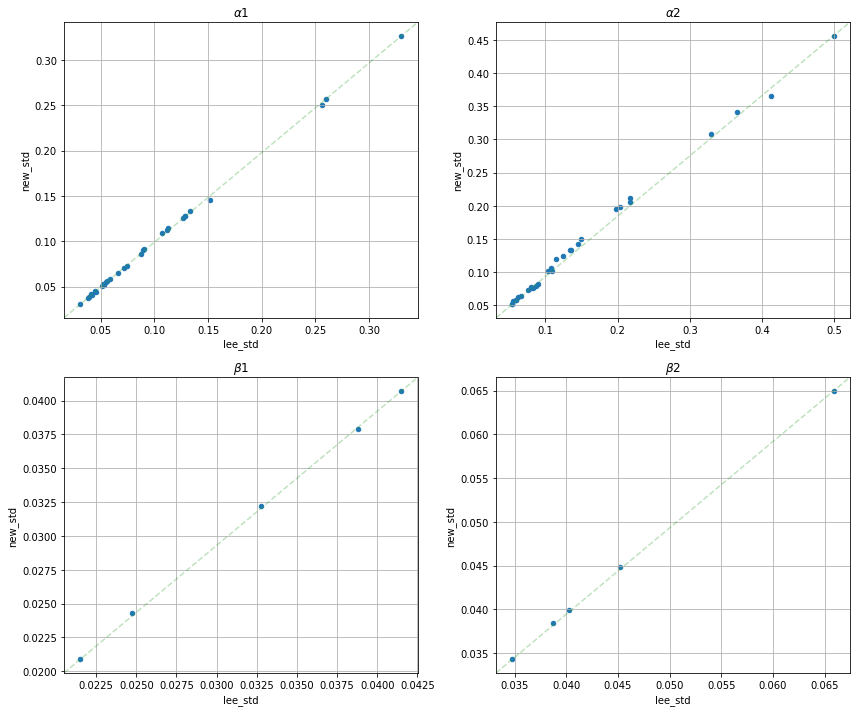

In [20]:
from pydts.examples_utils.plots import plot_boot_alpha_res

new_res_dict = plot_boot_alpha_res(boot_dict, True)

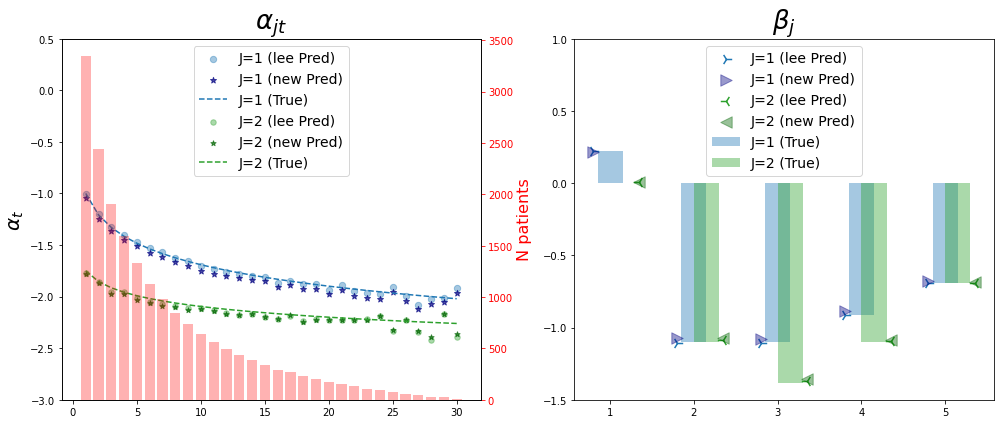

In [21]:
from pydts.examples_utils.plots import plot_models_coefficients
a = new_res_dict['alpha']
b = new_res_dict['beta']
times = train_df['X'].sort_values().unique()
n_cov = 5
temp_c_df = counts_df.loc[[1,2]].groupby(['X']).sum().values.flatten().astype(int)
plot_models_coefficients(a, b, times, temp_c_df)

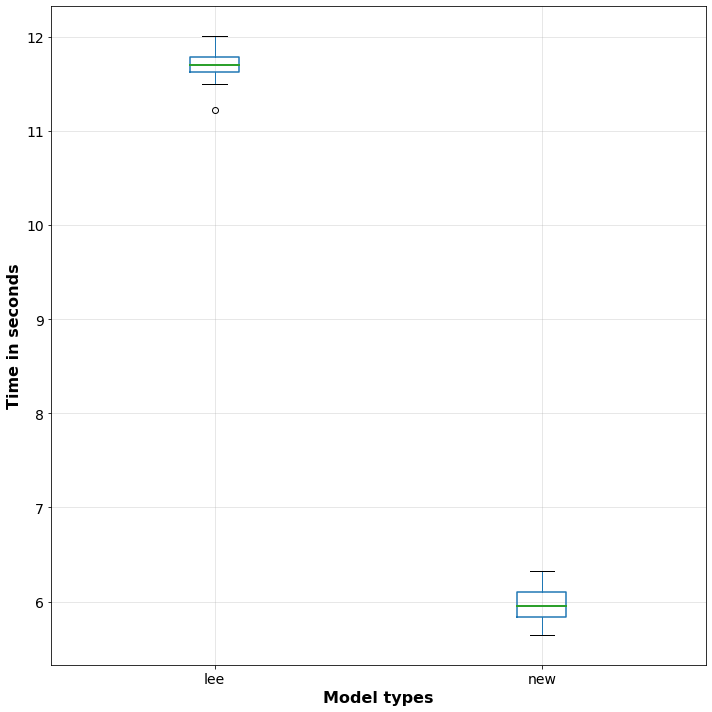

In [22]:
from pydts.examples_utils.plots import plot_times

plot_times(times_dict)